<a href="https://colab.research.google.com/github/seyedalirezamanavi/QuantumMonteCarlo/blob/master/GPU_version_and_errorless_measurment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# self learning determinantal quantum monte carlo

in this code we are going to implement a tool to find the effective hamiltonian of the Hubbard model using Deep Neural networks. with this effective hamiltonian we could update the configurations with much less time and computation costs. in the former method (DQMC), we have used the sherman morison method for local updates and it costs in order of $N^3$ which N is the system size. its because of many matrix multiplication is needed in sherman morison method while in SLDQMC we have at least in order of $N$ Speed up.

the following block we check our hardware. in colab we could use CPU or GPU. the colab may assign tesla K80 GPU or tesla P100. in the following link you will find the comparison between these two GPUs.
[P100 vs K80](https://www.xcelerit.com/computing-benchmarks/insights/nvidia-p100-vs-k80-gpu/)

long time computation in colab using GPUs are limited.

In [1]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.61
fastprogress  : 0.2.3
torch         : 1.5.0+cu101
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Feb 19 05:26:34 PST 2020
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-run

you can check the GPU load in the following block

In [2]:
!nvidia-smi

Mon Jun  8 16:31:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

mounting the google drive


[the corresponding data link](https://drive.google.com/drive/folders/1gsXD62fzf6hu0IPjDDzv3WeJp8JSDL0O?usp=sharing) "if you have problem with saving data in your google drive i can share it by your email"

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls "/content/drive/My Drive/Thesis/data/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
confs1m.npy    confs2m.npy   heff1m.npy    heff2m.npy
confs200k.npy  data3000.zip  heff200k.npy


after mounting the google drive we could load the configurations and corresponding energy which is made by DQMC to our note book. there exist 3 types of files

![alt text](https://drive.google.com/uc?id=1SFTZi6n8prjKkfzXiaCldhhuqKcNEHXw)


*  the files with 1m suffix contains 1 millions data sets 
>   the 2m file is constructed by concatenation of the 1m file and an extra 1 millions data sets.

*  the files with 2m suffix contains 2 millions data sets 
*  the files with 200k suffix contains 0.2 millions data sets 
    >   the 200k file is constructed just by generation of the confs and calculating the energy and the sherman morison is not used in this set.(just for having data in the region which we throw away at the warm up of monte carlo method.)

in the following block we load the data and split it to train and test sets.








In [0]:
from sklearn.utils import shuffle
import numpy as np
y = np.load("/content/drive/My Drive/Thesis/data/heff2m.npy")
x = np.load("/content/drive/My Drive/Thesis/data/confs2m.npy")
y, x = shuffle(y, x)

In [0]:
# y1 = np.load("/content/drive/My Drive/Thesis/data/heff1m.npy")
# x1 = np.load("/content/drive/My Drive/Thesis/data/confs1m.npy")
# y2 = np.load("/content/drive/My Drive/Thesis/data/heff2m.npy")
# x2 = np.load("/content/drive/My Drive/Thesis/data/confs2m.npy")
# x = np.append(x1,x2,axis=0)
# y = np.append(y1,y2,axis=0)
# print("confs shape:",np.shape(x),"heff shape:",np.shape(y))

y_, x_ = shuffle(y, x)
x1,x2,y1,y2 = 0,0,0,0
l = 1900000
x = x_[:l]
y = y_[:l]
y_test = y_[l:]
x_test = x_[l:]
x_test = np.array([np.reshape(xx,(40,10,1)) for xx in x_test])
x_, y_ = 0, 0

x_train = np.array([np.reshape(xx,(40,10,1)) for xx in x])
y_train = y
x, y = 0, 0

the following block is used to normalize data by subtracting the mean and dividing by the maximum.

its not needed to run it because i got a bad performance by this normalization.

In [0]:
# print(np.mean(y_train),np.mean(y_test),)
# trainmean, testmean = np.mean(y_train), np.mean(y_test)
# y_train -= trainmean
# y_test -= testmean
# print(np.max(y_train),np.max(y_test))
# ymax = np.max(y_train)
# y_train /= ymax
# y_test /= ymax

histogram of energies

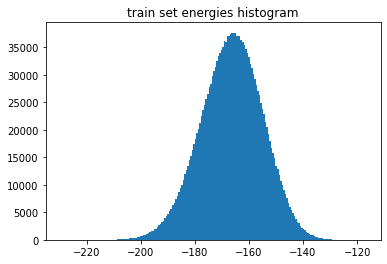

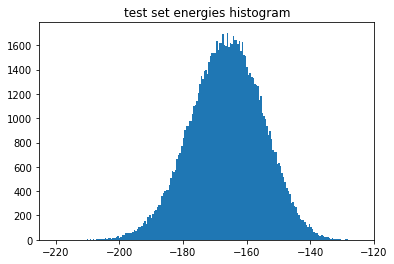

In [0]:
import matplotlib.pyplot as plt
plt.hist(y_train,200);
plt.title("train set energies histogram")
plt.show()

plt.hist(y_test,200);
plt.title("test set energies histogram")
plt.show()

In [0]:
from tensorflow import keras
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, x, y, batch_size=32,
                 shuffle=True):
        'Initialization'
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        # self.sflag = 0
        self.on_epoch_end()


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        'Generate one batch of data'
        # Generate indexes of the batch

        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size].copy()
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size].copy()
        batch_x = np.array([np.reshape(xx,(40,10,1)) for xx in batch_x])

        return (np.array(batch_x),np.array(batch_y))

    def on_epoch_end(self):
        # print("sh")
        # self.sflag+=1
        self.indexes = np.arange(len(self.x))   
        if self.shuffle:
            np.random.shuffle(self.indexes)

the following class is a costumized keras layer used to implement the periodic boundary paddings. 

In [0]:
from tensorflow import pad
from tensorflow.keras.layers import Layer

'''
  2D Replication Padding
  Attributes:
    - padding: (padding_width, padding_height) tuple
'''
class ReplicationPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReplicationPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + 2 * self.padding[0], input_shape[2] + 2 * self.padding[1], input_shape[3])

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'padding': self.padding,
        })
        return config
        
    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        return pad(input_tensor, [[0,0], [padding_height, padding_height], [padding_width, padding_width], [0,0] ], 'SYMMETRIC')

the following block is the core of the Deep learning design we have implemented.

it is constructed of several convulutional neural networks and a dense layer. the design is as following
![second](https://drive.google.com/uc?id=1y79dp36UuGGv5DtnmeqZf8pnAIpZFX3i)

![first](https://drive.google.com/uc?id=1VicC6ve5IZd1Q7z1kNodue6xHiPru-3G)

the activation functions in dense layers may not help us as I tested severals. this is one of my questions. while we know that having a layer with out activation forces the model to be linear. how can we use this activation function with dense layer and also have the model converged.
the learnwed weights could be accessed through here [best8m.py](https://drive.google.com/file/d/1-7V8qtgAXr0POBG-XUP2YssKf4ozZfJp/view?usp=sharing)

In [0]:
# importing block
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,LocallyConnected2D,Input,AveragePooling2D,ConvLSTM2D
from tensorflow.keras.callbacks import TensorBoard
import time
from keras import optimizers
import keras.backend as K

# defining matrices for the model to find out whether the model converges or not
def difference(y_true, y_pred):
    return K.sum(K.abs(-y_pred+y_true))

def conv(y_true,y_pred):
    y_true_p = tf.roll(y_true,1,axis=0)
    y_pred_p = tf.roll(y_pred,1,axis=0)
    r = tf.exp(-y_pred_p+y_pred+y_true_p-y_true)
    return K.mean(1-r)

def var(y_true,y_pred):
    y_true_p = tf.roll(y_true,1,axis=0)
    y_pred_p = tf.roll(y_pred,1,axis=0)
    r = -y_pred_p+y_pred+y_true_p-y_true
    return K.var(r)


# the core neural network model design
nodes = 200

NAME = '{}-nodes'.format(nodes)+str(int(time.time()))
model = tf.keras.models.Sequential()
model.add(Input(shape = [40,10,1])) #input layer

for i in range(2): #convs
    model.add(ReplicationPadding2D((6,4)))
    
    model.add(Conv2D(nodes, (13,9)))
    # model.add(MaxPooling2D((2,2)))
    model.add(Activation('softmax'))

model.add(MaxPooling2D((4,2)))
# model.add(ReplicationPadding2D((1,1)))
model.add(Conv2D(nodes, (4,4)))
model.add(Activation('relu'))
model.add(Dense(120)) #dense layed
model.add(Activation("sigmoid"))
model.add(Dense(100)) #dense layed
model.add(Activation("sigmoid"))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
# model.add(Dropout(0.1))  
model.add(Dense(1))
# model.add(Activation("relu"))

print(model.summary())

logdir="/content/drive/My Drive/Thesis/logs/{}".format(NAME)
tensorboard = TensorBoard(log_dir=logdir,update_freq="epoch")
adam = tf.keras.optimizers.Adam()


model.load_weights("/content/drive/My Drive/Thesis/best5_4m.h5")

# model.compile(loss="mse",
#             optimizer="adam",
#             metrics=['mae', difference, conv, var])


# model.fit(x_train,y_train, epochs = 1, validation_split=0.1, verbose = 1, batch_size = 300)
#   model.save_weights("/content/drive/My Drive/Thesis/best8m.h5")

# !nvidia-smi

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
replication_padding2d_6 (Rep (None, 48, 22, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 36, 14, 200)       23600     
_________________________________________________________________
activation_5 (Activation)    (None, 36, 14, 200)       0         
_________________________________________________________________
replication_padding2d_7 (Rep (None, 44, 26, 200)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 18, 200)       4680200   
_________________________________________________________________
activation_6 (Activation)    (None, 32, 18, 200)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 9, 200)        

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



def design(layer_name,model_name):

    layer = keras.Input(shape=(40, 10, 1), name=layer_name)

    x = ReplicationPadding2D((2,2))(layer)
    x = layers.Conv2D(128, 5)(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = ReplicationPadding2D((1,1))(x)
    x = layers.Conv2D(128, 3)(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = ReplicationPadding2D((1,1))(x)
    x = layers.Conv2D(256, 3)(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D((2,1))(x)

    x = ReplicationPadding2D((1,1))(x)
    x = layers.Conv2D(256, 3)(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)

    # x = ReplicationPadding2D((1,1))(x)
    # x = layers.Conv2D(512, 3)(x)
    # x = layers.BatchNormalization()(x)
    # x = keras.activations.relu(x)

    # x = ReplicationPadding2D((1,1))(x)
    # x = layers.Conv2D(512, 3)(x)
    # x = layers.BatchNormalization()(x)
    # x = keras.activations.relu(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(128,activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512,activation="relu")(x)
    x = layers.BatchNormalization()(x)   
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)   
    output = layers.Dense(1)(x)
    return layer,output

input_layer, output_layer = design("prev_layer","prev")

model = keras.Model(
        inputs=[input_layer],
        outputs=[output_layer],
    )


print(model.summary())



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prev_layer (InputLayer)      [(None, 40, 10, 1)]       0         
_________________________________________________________________
replication_padding2d (Repli (None, 44, 14, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 10, 128)       3328      
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 10, 128)       512       
_________________________________________________________________
tf_op_layer_Relu (TensorFlow [(None, 40, 10, 128)]     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 5, 128)        0         
_________________________________________________________________
replication_padding2d_1 (Rep (None, 22, 7, 128)        0     

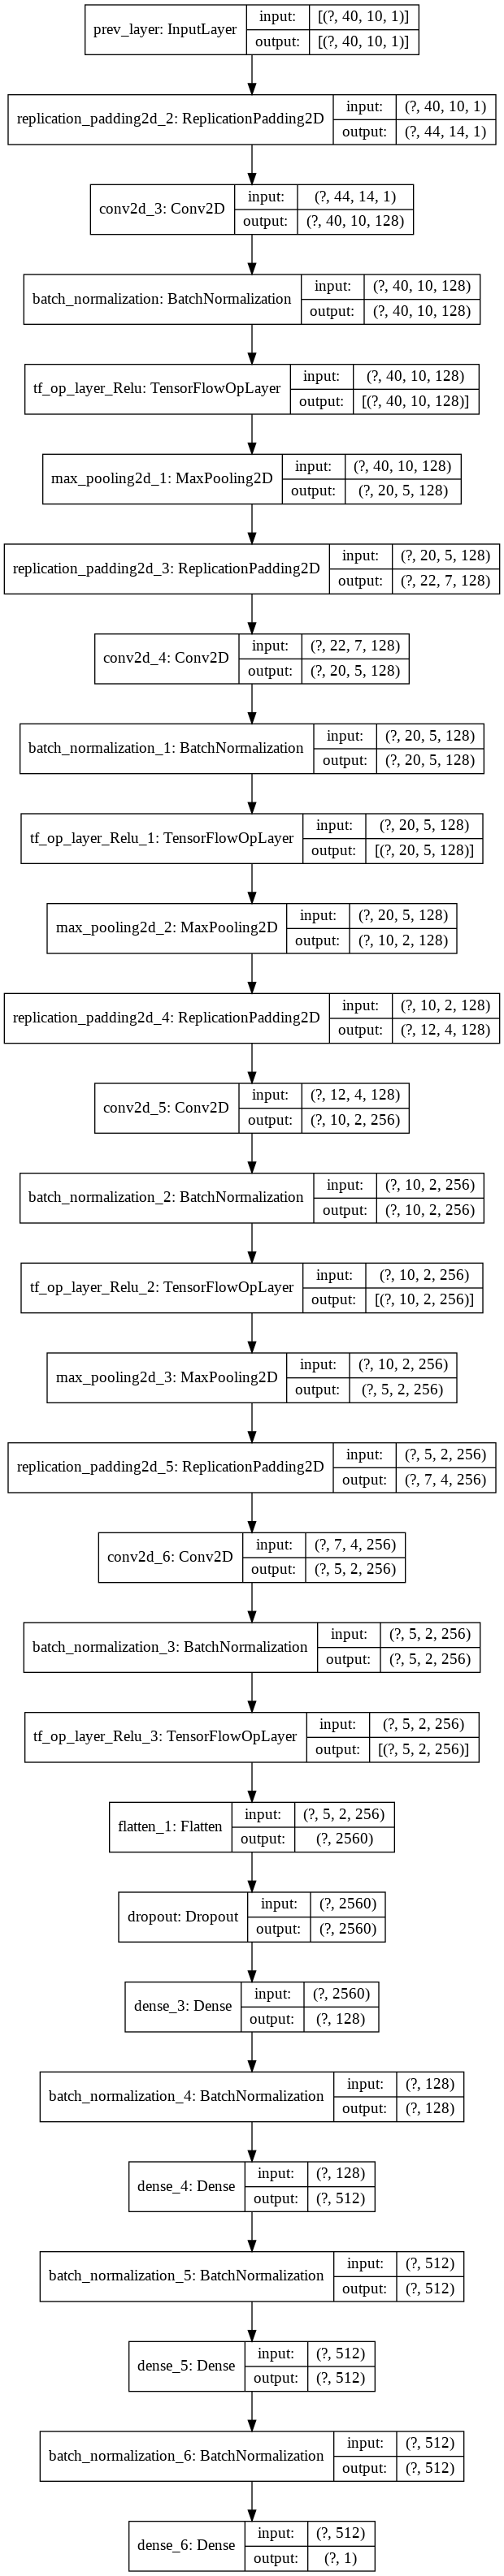

In [0]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)


In [8]:
from keras import optimizers
import keras.backend as K
# logdir="/content/drive/My Drive/Thesis/logs/{}".format(NAME)
# tensorboard = TensorBoard(log_dir=logdir,update_freq="epoch")
# adam = tf.keras.optimizers.Adam()


model.load_weights("/content/drive/My Drive/Thesis/latest07.h5")



model.compile(loss="mse",
            optimizer = keras.optimizers.Adam(),
            metrics=['mae']
            )

v = 1800000
t = 1900000
bs = 2048
train_generator = DataGenerator(x[:v], y[:v], bs)
val_generator = DataGenerator(x[v:t], y[v:t], bs)
test_generator = DataGenerator(x[t:], y[t:], bs)
# model.fit(train_generator, verbose = 1, epochs=1, validation_data=val_generator,)
# model.fit(x_train,y_train, epochs = 30, validation_split=0.2, verbose = 1, batch_size = 512)

#   model.save_weights("/content/drive/My Drive/Thesis/best8m.h5")

# !nvidia-smi

Using TensorFlow backend.


In [0]:
model.fit(train_generator, verbose = 2, epochs=10, validation_data=val_generator)

Epoch 1/10
879/879 - 82s - loss: 0.6280 - mae: 0.6258 - val_loss: 0.8390 - val_mae: 0.6962
Epoch 2/10
879/879 - 82s - loss: 0.6302 - mae: 0.6272 - val_loss: 0.8045 - val_mae: 0.6805
Epoch 3/10
879/879 - 82s - loss: 0.6134 - mae: 0.6188 - val_loss: 1.1200 - val_mae: 0.8300
Epoch 4/10
879/879 - 82s - loss: 0.6221 - mae: 0.6238 - val_loss: 0.9559 - val_mae: 0.7467
Epoch 5/10
879/879 - 82s - loss: 0.6192 - mae: 0.6217 - val_loss: 0.8944 - val_mae: 0.7192
Epoch 6/10
879/879 - 82s - loss: 0.6350 - mae: 0.6298 - val_loss: 1.1209 - val_mae: 0.8294
Epoch 7/10
879/879 - 82s - loss: 0.6098 - mae: 0.6171 - val_loss: 0.8302 - val_mae: 0.6921
Epoch 8/10
879/879 - 82s - loss: 0.6179 - mae: 0.6216 - val_loss: 0.9365 - val_mae: 0.7450
Epoch 9/10
879/879 - 82s - loss: 0.6165 - mae: 0.6211 - val_loss: 0.9325 - val_mae: 0.7401
Epoch 10/10
879/879 - 82s - loss: 0.6162 - mae: 0.6207 - val_loss: 0.8639 - val_mae: 0.7092


In [0]:
?model.fit

In [0]:
model.save_weights("/content/drive/My Drive/Thesis/latest07.h5")


in the following block the learned model evaluated by the test set.

In [0]:
# v = 800000
# t = 900000
# train_generator = DataGenerator(x[:v], y[:v], 512)
# val_generator = DataGenerator(x[v:t], y[v:t], 512)
# test_generator = DataGenerator(x[t:], y[t:], 512)

model.evaluate(test_generator)

49/49 [==============================] - 1s 29ms/step - loss: 0.4512 - mae: 0.5240


[0.4512118995189667, 0.5239918231964111]

what is important for us is that how much the exponential of the predicted energies are close to the exact energies we have. so we should calculate the following blocks. 
first we predict the energies of the test set in the following block.

In [0]:
pre = model.predict(test_generator)
np.shape(pre)

(100000, 1)

In [0]:
y_test = np.array(y[t:]).reshape(-1,1)
np.shape(y_test)

(100000, 1)

Text(0.5, 1.0, 'Energy error percentage')

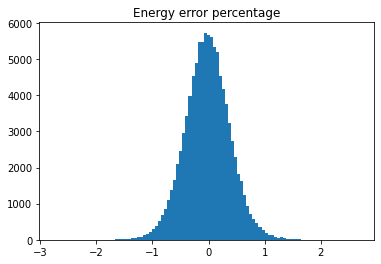

In [0]:
import matplotlib.pyplot as plt

plt.hist((pre-y_test)/y_test*100,100);
plt.title("Energy error percentage")

Text(0.5, 1.0, 'exponential of the ratio error')

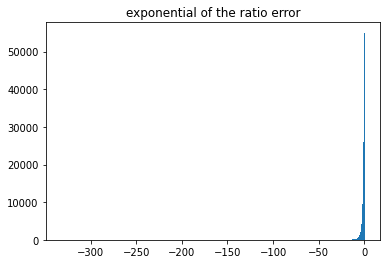

In [0]:
pre_p = np.roll(pre,1)
y_test_p = np.roll(y_test,1)
plt.hist(np.sort(1-np.exp((-pre_p + y_test_p - y_test + pre)))[:],300);
plt.title("exponential of the ratio error")

in this block we plot the histogram of the difference percentage of the predicted enegies and the exact energies we have.

In [0]:
import matplotlib.pyplot as plt

pre = model.predict(x_test)
plt.hist((pre.T-y_test)[0]/y_test[0]*100,100);
plt.title("Energy error percentage")
plt.show()
pre_p = np.roll(pre,1)
y_test_p = np.roll(y_test,1)
plt.hist(np.sort(1-np.exp((-pre_p.T + y_test_p - y_test + pre.T)[0]))[1000:],300);
plt.title("exponential of the ratio error")

NameError: ignored

Text(0.5, 1.0, 'Energy error percentage')

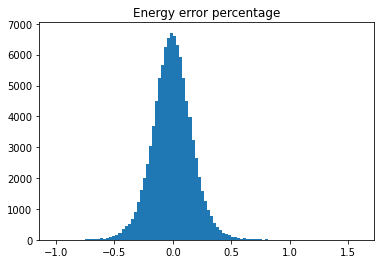

In [0]:
plt.hist((pre.T-y_test)[0]/y_test[0]*100,100);
plt.title("Energy error percentage")

the following plot is the histogram of the subtraction of exponentials of the exact and predicted energies devided by exponential of exact energies:

$(\exp(ExactEnergy'-ExactEnergy) - \exp(PredictedEnergy'-PredictedEnergy))/\exp(ExactEnergy'-ExactEnergy)$

Text(0.5, 1.0, 'exponential of the ratio error')

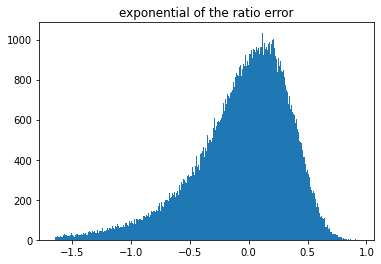

In [0]:
pre_p = np.roll(pre,1)
y_test_p = np.roll(y_test,1)
plt.hist(np.sort(1-np.exp((-pre_p.T + y_test_p - y_test + pre.T)[0]))[1000:],300);
plt.title("exponential of the ratio error")



the following class is the method we implemented to calculate the exact energy using DQMC. this is used in cummulative update.


In [0]:
!pip install pythran


     |████████████████████████████████| 3.6MB 2.7MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
  Created wheel for pythran: filename=pythran-0.9.5-cp36-none-any.whl size=4066521 sha256=a1aedce5b57bcd0108c608ce58ce66bf31c479a5909d8a28bc3403cd05490ba8
  Stored in directory: /root/.cache/pip/wheels/b5/4c/4f/3e8c360280dd141601ddc0cd9f243216f1ef90447faee31764
  Created wheel for beniget: filename=beniget-0.2.1-cp36-none-any.whl size=9300 sha256=fb084dde51840e0192482d3231727d0c3960524b6cf103fff86ef8340d8a0f4c
  Stored in directory: /root/.cache/pip/wheels/4c/86/26/037f3b2e6bf5c14b1732e8d3bdbb2b90da6bb77c5d15d83b41
Successfully built pythran beniget


In [0]:
class SLDQMC():
    
    def __init__(self,t_x,t_y,t_xy,mu,U,DT,beta,Nx,Ny,bnd_x,bnd_y):
        self.t_x=t_x
        self.t_y=t_y
        self.t_xy=t_xy
        self.mu=mu
        self.U=U
        self.Nx=Nx
        self.Ny=Ny
        self.bnd_x = bnd_x
        self.bnd_y = bnd_y
        self.DT = DT
        self.L = int(beta/self.DT)
        self.beta = beta
        self.lamda = np.arccosh(np.exp(self.U*self.DT/2))
        self.Ns = Nx*Ny
        
    def kinetic(self):
        #Constructing the matrix of hopping amplitudes for a 2D square lattice
        dx = 1 # range of hopping along x
        rx_max = dx # range of hopping along x
        if self.Nx == 1:
            rx_max = 0
        elif self.Nx < 5:
            rx_max = 1
        
        dy = 1 #range of hopping along y
        ry_max = dx # range of hopping along y
        if self.Ny == 1:
            ry_max = 0
        elif self.Ny < 5:
            ry_max = 1
        

        # hopping amplitudes from sit i to its nearest and next nearest neighbors
        T = [[self.t_xy,self.t_x,self.t_xy],
            [ self.t_y ,0  ,self.t_y ],
            [ self.t_xy,self.t_x,self.t_xy]]
        T = np.dot(-1,T)
        # hopping matrix
        H0 = np.zeros((self.Nx*self.Ny,self.Nx*self.Ny))
        
        for i1 in range(self.Nx):
            for i2 in range ( self.Ny ):
                
                r1 = i1*self.Ny + i2 # index of site r1 = (i1,i2)
                for rx in range(-rx_max,rx_max+1):
                    j1 = i1 + rx
                    if self.bnd_x == 1:
                        j1 = np.mod(j1,self.Nx)
                    for ry in range(-ry_max,ry_max+1):
                        j2 = i2 + ry
                        if self.bnd_y == 1:
                            j2 = np.mod(j2,self.Ny)
                        

                        r2 = j1*self.Ny + j2 # index of site r2 = (j1,j2)
                        if j1>=0 and j1 < self.Nx:
                            if j2 >=0 and j2 < self.Ny:
                                #print(r1,r2)
                                H0[r1,r2] = T[rx+dx,ry+dy]
                                H0[r2,r1] = H0[r1,r2]
                        
        H0 = (H0 + H0.transpose())/2
        H0 += np.eye(len(H0)) * (-self.mu)
        H0 = np.dot(self.DT,H0) 
        return H0
        
    def interaction(self):
        v = np.dot(self.lamda,np.power(-1,np.random.randint(2,size=(self.L,self.Nx*self.Ny)) ))
        return v

    def qr_decomposition(self,M_i,T0):
        [Q,R] = LA.qr(M_i)
        D0 = np.diag(R)
        inv_D = np.diag(1/D0)
        D = np.diag(D0)
        T = np.dot(np.dot(inv_D,R),T0)
        return Q,D,T 
    
    def lu_decomposition(self,A1,D_b,A3):
        _,L1,U1 = LA.lu(A1)

        log_det_L1 = 0
        sign_det_L1 = np.sign(LA.det(L1))
        log_det_U1 = np.sum(np.log(np.abs(np.diag(U1))))
        sign_det_U1 = np.prod(np.sign(np.diag(U1)))
        log_det_A1 = log_det_L1 + log_det_U1
        sign_det_A1 = sign_det_L1*sign_det_U1

        log_det_A2 = -np.sum(np.log(np.abs(D_b)))
        sign_det_A2 = np.prod(np.sign(D_b))

        log_det_A3 = 0
        sign_det_A3 = np.sign(LA.det(A3))

        sign_det_G = sign_det_A1*sign_det_A2*sign_det_A3 # sign of det(G)
        log_det_G = -log_det_A1+log_det_A2+log_det_A3 # log of abs(det(G))
        return log_det_G,sign_det_G
        
    def partition_sigma(self,v,expmk,alpha,p_vec):
        Q = np.eye(np.shape(expmk)[0])
        D = np.eye(np.shape(expmk)[0])
        T = np.eye(np.shape(expmk)[0])
        i = 0
        while i < len(v):
            B = np.dot(expmk,LA.expm(np.dot(alpha,np.diag(v[i]))))
            i+=1
            while i < len(v) and p_vec[i]<1:
                b = np.dot(expmk,LA.expm(np.dot(alpha,np.diag(v[i]))))
                B = np.matmul(b,B)
                i+=1
            C = np.matmul(np.matmul( B , Q ), D)
            Q, D, T = self.qr_decomposition(C,T)
        return Q, D, T


    
    
    def initialize_green_function(self,expmk,v,alpha,p_vec):  
        Q, D, T = self.partition_sigma(v,expmk,alpha,p_vec)
        D_diag = np.diag(D)
        D_b = np.multiply(np.maximum(np.ones(np.shape(D_diag)),np.abs(D_diag)),np.sign(D_diag))
        D_s = np.minimum(np.ones(np.shape(D_diag)),np.abs(D_diag)) 
        inv_D_b = np.diag(np.divide(1,D_b))
        D_s = np.diag(D_s)
        A1 = np.add(np.matmul(inv_D_b,(Q.transpose())) ,np.matmul( D_s , T))
        A2 = inv_D_b
        A3 = Q.transpose()
        G = np.matmul(LA.solve(A1,A2),A3)
        log_det_G,sign_det_G = self.lu_decomposition(A1,D_b,A3)
        return G,log_det_G,sign_det_G
    
    



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import linalg as LA
from scipy.sparse import spdiags
import numba
from numba import int64, float64  

hubbard = SLDQMC(t_x=1,t_y=1,t_xy=0,mu=0,U=4,DT = 1/8 ,beta=5,Nx=10, Ny=1, bnd_x=1,bnd_y=1)
k = hubbard.kinetic()
expmk = LA.expm(-k)
expmkkr = LA.expm(k/2)
expmkr = LA.expm(-k/2)
p_vec=np.zeros(hubbard.L)
for i in range(10,hubbard.L,10):
    p_vec[i]=1 
p_vec[-1] = 1



the following class is for measuring different measurables.( the mean energy and z component of spin correlation is implemented completely.)

*  the Greens function is implemented to calculated temporal greens function and temporal density in each cummulative update level.

*  density function is used to calculate "GF_up_tmp, n_up_tmp, GF_dn_tmp, n_dn_tmp, sz_tmp, rho_tmp, n_up_dn"

*  correlation is yet not complete and just calculate the sz correlation

*  energy_avg function is used to calculate mean energy

In [0]:
class measurement():

    def __init__(self, U, mrk):
        self.U = U
        self.cummulative_update_prev_energy = [None]*mrk

    def H(self, v, expmk, p_vec):
        Gu,log_det_G_up,sign_det_G_up = hubbard.initialize_green_function(expmk,v,1,p_vec)
        Gd,log_det_G_dn,sign_det_G_dn = hubbard.initialize_green_function(expmk,v,-1,p_vec)
        # sign *= sign_det_G_up*sign_det_G_dn
        sign = np.sign(LA.det(Gu))*np.sign(LA.det(Gu))
        return (log_det_G_dn+log_det_G_up), Gu, Gd, sign

    def local_update(self, model, S):

        S = np.array(S)

        for j in range(np.shape(S)[1]):
            for i in range(np.shape(S)[2]):
                Sp = S.copy()
                Sp[:,j,i] = -Sp[:,j,i]
                conf = np.append(S,Sp,axis=0)
                H = model.predict(conf,batch_size=len(conf))
                Hef = H[:len(S)]
                Hefp = H[len(S):]
                r = np.exp(-(Hefp-Hef))
                for k in range(len(S)):
                    if r[k]>np.random.random():
                        S[k,:] = Sp[k,:].copy()
                
                        # print("accepted",r[k])
                    # else:
                        # print("rejected",r[k])
        return S


    def cummulative_update(self,model, S, Sp, expmk, expmkkr, expmkr, p_vec, sign):
        
        Hef = model.predict(S)
        Hefp = model.predict(Sp)
        signp = 1
        mda = []
        corz = np.zeros((np.shape(S)[0],10))
        corx = np.zeros((np.shape(S)[0],10))
        corrho = np.zeros((np.shape(S)[0],10))
        nm = np.zeros((np.shape(S)[0],1))
        for i in range(np.shape(S)[0]):
            if self.cummulative_update_prev_energy[i] == None:
                Ha, _, _, _ = self.H(S[i,:,:,0],expmk,p_vec)
                Hap, Gup, Gdp, signp = self.H(Sp[i,:,:,0],expmk,p_vec)
                r = np.exp(-(Hap - Ha)-(Hef[i]-Hefp[i]))
                if r>np.random.random():
                    # print("accepted")
                    S[i] = Sp[i].copy()
                    sign[i] *= signp

                    GF_up, n_up_tmp, GF_dn, n_dn_tmp, sz_tmp, rho_tmp, n_up_dn = measure.density(Gup, Gdp, expmkr, expmkkr, hubbard.Ns, sign[i])
                    md = [GF_up, n_up_tmp, GF_dn, n_dn_tmp, sz_tmp, rho_tmp, n_up_dn]
                    corz[i,:],corx[i,:],corrho[i,:] = measure.correlation(md, hubbard.Ns)
                    E = measure.energy_avg(n_up_dn, k/0.125, GF_up+GF_dn , hubbard.Ns)

                    nm[i,0] = signp
                    self.cummulative_update_prev_energy[i] =  Hap.copy()
                    
                else:
                    self.cummulative_update_prev_energy[i] =  Ha.copy()
                    # print("rejected")
            else:
                Ha = self.cummulative_update_prev_energy[i]
                Hap, Gup, Gdp, signp = self.H(Sp[i,:,:,0],expmk,p_vec)
                r = np.exp(-(Hap - Ha)-(Hef[i]-Hefp[i]))
                if r>np.random.random():
                    # print("accepted")
                    S[i] = Sp[i].copy()
                    sign[i] *= signp

                    GF_up, n_up_tmp, GF_dn, n_dn_tmp, sz_tmp, rho_tmp, n_up_dn = measure.density(Gup, Gdp, expmkr, expmkkr, hubbard.Ns, sign[i])
                    md = [GF_up, n_up_tmp, GF_dn, n_dn_tmp, sz_tmp, rho_tmp, n_up_dn]
                    corz[i,:],corx[i,:],corrho[i,:] = measure.correlation(md, hubbard.Ns)
                    E = measure.energy_avg(n_up_dn, k/0.125, GF_up+GF_dn , hubbard.Ns)

                    nm[i,0] = signp
                    self.cummulative_update_prev_energy[i] =  Hap.copy()
                    
                else:
                    self.cummulative_update_prev_energy[i] =  Ha.copy()
                    # print("rejected")

        return S,md,sign,corz,corx,corrho,E,nm

    def Greens(self, G, expmkkr, expmkr, N_s, sign):
        GF_tmp = np.eye(N_s) - expmkkr.dot(G).dot(expmkr)
        n_tmp = np.diag(GF_tmp)
        GF = GF_tmp * sign
        return GF, n_tmp
    
    def density(self, G_up, G_dn, expmkkr, expmkr, N_s, sign):
        GF_up_tmp, n_up_tmp = self.Greens(G_up, expmkkr, expmkr, N_s, sign)
        GF_dn_tmp, n_dn_tmp = self.Greens(G_dn, expmkkr, expmkr, N_s, sign)
        sz_tmp = (n_up_tmp - n_dn_tmp)/2
        rho_tmp = (n_up_tmp + n_dn_tmp)/2
        n_up_dn = n_up_tmp * n_dn_tmp*sign 

        return GF_up_tmp, n_up_tmp, GF_dn_tmp, n_dn_tmp, sz_tmp, rho_tmp, n_up_dn

    def correlation(self, data, N_s):
        # GF_up_tmp, GF_dn_tmp, sz_tmp, rho_tmp, n_up_tmp, n_dn_tmp, 
        # md[:,0], md[:,2], md[:,4], md[:,5], md[:,1], md[:,3]
        corr_z_list = 0
        corr_x_list = 0
        rho_list = 0
        for i in range(N_s):
            GF_up_shifted = np.multiply(np.roll(data[0][i,:],-i), np.roll(data[0][:,i],-i))
            GF_dn_shifted = np.multiply(np.roll(data[2][i,:],-i), np.roll(data[2][:,i],-i))
            
            szshifted = np.roll(data[4],-i)
            corr_z = szshifted[0]*szshifted - (GF_up_shifted + GF_dn_shifted)/4
            corr_z[0] = -data[1][i]*data[3][i]/2 + data[5][i]/2
            corr_z_list = np.add(corr_z_list,corr_z)

            corr_x = -np.multiply(np.roll(data[0][i,:],-i), np.roll(data[2][:,i],-i))/2
            corr_x[0] = data[1][i]*(1 - data[3][i])/2 
            corr_x_list = np.add(corr_x_list,corr_x)

            rhoshifted = np.roll(data[5],-i)
            rho = rhoshifted[0]*rhoshifted - (GF_up_shifted + GF_dn_shifted)/4
            rho[0] = data[1][i]*data[3][i]/2 + data[5][i]/2
            rho_list = np.add(rho_list,rho)

        szsz_correlation = corr_z_list/N_s
        sxsx_correlation = corr_x_list/N_s
        rho_correlation = rho_list/N_s

        return np.array(szsz_correlation),np.array(sxsx_correlation),np.array(rho_correlation)


    def energy_avg(self, n_up_dn, hopping, GF, N_s):
        # print("avg",np.sum(n_up_dn),np.trace(hopping.dot(GF)))
        return (self.U * np.sum(n_up_dn) + np.trace(hopping.dot(GF)))/N_s



the following functions are used to implement local update and cummulative update

* the H function is calculate the exact energy used in cummulative update and measure the measurements.
    > the md variable contains GF_up, n_up_tmp, GF_dn, n_dn_tmp, sz_tmp, rho_tmp, n_up_dn

    > the sign is calculated directly from Greens function of up and down spins

* the local_update function uses the learned model to calculate the effective energy of a configuration. then flip a spin and calculate the effective energy of this new configuration. after that, we used metropolis method to whether accept or reject the changed configuration. the acceptence ratio is $\exp(heff' - heff)$.

* the cummulative_update uses the learned model and the H function to calculate the acceptence ratio of the metropolic method as 
$\exp(-ExactEnergy′ + ExactEnergy + PredictedEnergy′- PredictedEnergy)$


In [0]:
def H(v,expmk,p_vec):
    measure = measurement(hubbard.U)
    Gu,log_det_G_up,sign_det_G_up = hubbard.initialize_green_function(expmk,v,1,p_vec)
    Gd,log_det_G_dn,sign_det_G_dn = hubbard.initialize_green_function(expmk,v,-1,p_vec)
    # sign *= sign_det_G_up*sign_det_G_dn
    sign = np.sign(LA.det(Gu))*np.sign(LA.det(Gu))
    return (log_det_G_dn+log_det_G_up), Gu, Gd, sign

def local_update(S):

    S = np.array(S)

    for j in range(np.shape(S)[1]):
        for i in range(np.shape(S)[2]):
            Sp = S.copy()
            Sp[:,j,i] = -Sp[:,j,i]
            conf = np.append(S,Sp,axis=0)
            H = model.predict(conf,batch_size=len(conf))
            Hef = H[:len(S)]
            Hefp = H[len(S):]
            r = np.exp(-(Hefp-Hef))
            for k in range(len(S)):
                if r[k]>np.random.random():
                   S[k,:] = Sp[k,:].copy()
            
                    # print("accepted",r[k])
                # else:
                    # print("rejected",r[k])
    return S


def cummulative_update(S,Sp,expmk,expmkkr,expmkr,p_vec,sign,measrument_flag):
       
    Hef = model.predict(S)
    Hefp = model.predict(Sp)
    signp = 1
    mda = []
    corz = np.zeros((np.shape(S)[0],10))
    corx = np.zeros((np.shape(S)[0],10))
    corrho = np.zeros((np.shape(S)[0],10))
    nm = np.zeros((np.shape(S)[0],1))
    for i in range(np.shape(S)[0]):
        Ha, Gu, Gd, _ = H(S[i,:,:,0],expmk,p_vec)
        Hap, Gup, Gdp, signp = H(Sp[i,:,:,0],expmk,p_vec)
        r = np.exp(-(Hap - Ha)-(Hef[i]-Hefp[i]))
        if r>np.random.random():
            # print("accepted")
            S[i] = Sp[i].copy()
            sign[i] *= signp

            GF_up, n_up_tmp, GF_dn, n_dn_tmp, sz_tmp, rho_tmp, n_up_dn = measure.density(Gup, Gdp, expmkr, expmkkr, hubbard.Ns, sign[i])
            md = [GF_up, n_up_tmp, GF_dn, n_dn_tmp, sz_tmp, rho_tmp, n_up_dn]
            np.save("GU.npy",GF_up+GF_dn)
            corz[i,:],corx[i,:],corrho[i,:] = measure.correlation(md, hubbard.Ns)
            E = measure.energy_avg(n_up_dn, k/0.125, GF_up+GF_dn , hubbard.Ns)

            nm[i,0] = signp
            # mda.append(md)
            
        # else:
            # mda.append(md.copy())
            # print("rejected")
    return S,md,sign,corz,corx,corrho,E,nm


the following code is just to initialize the hubbard model.

the following block implement the markovs and measurments of the SLDQMC and add up measurments.

In [0]:
%%time
mrk = 100
nms = 10
measure = measurement(hubbard.U, mrk)
nwa = int(nms/4)
S = np.array([np.reshape(hubbard.interaction(),(40,10,1)) for i in range(mrk)])
sign = np.array([1 for i in range(mrk)])
sgnz = np.zeros((mrk,))

corzl = np.zeros((np.shape(S)[0],10))
corxl = np.zeros((np.shape(S)[0],10))
corrhol = np.zeros((np.shape(S)[0],10))
El = 0
nml = np.zeros((np.shape(S)[0],1))

for j in range(nms+nwa):
    print("measure",j)

    Sp = measure.local_update(model, S)
    S,mda,sign,corz,corx,corrho,E,nm = measure.cummulative_update(model,S,Sp,expmk,expmkkr,expmkr,p_vec,sign)
    sgnz = np.add(sign,sgnz)
    if j > nwa:
        measrument_flag = 1
        corzl += corz
        corxl += corx
        corrhol += corrho
        El += E
        nml += nm

sgnz = nms

sz_avg = np.sum(corzl,axis=0) /np.sum(nml)
sx_avg = np.sum(corxl,axis=0) /np.sum(nml)
rho_avg = np.sum(corrhol,axis=0) /np.sum(nml)

measure 0
measure 1
measure 2
measure 3
measure 4
measure 5
measure 6
measure 7
measure 8
measure 9
measure 10
measure 11
CPU times: user 3min 51s, sys: 2min 35s, total: 6min 26s
Wall time: 4min 2s


In [0]:

sz_avg = np.sum(corzl,axis=0) /np.sum(nml)
sx_avg = np.sum(corxl,axis=0) /np.sum(nml)
rho_avg = np.sum(corrhol,axis=0) /np.sum(nml)


In [0]:
d = np.load("GU.npy")
np.trace(k.dot(d)/0.125)


-6.745579614107202

In [0]:
np.roll(d[i,:],-i), np.roll(d[:,i],-i)

(array([ 1.00163652e+00,  2.23654174e-02,  1.40196528e-04, -9.13160247e-03,
         2.46789088e-05,  3.89976650e-03, -1.09294183e-03, -1.58482286e-03,
         5.77717985e-03, -2.18712347e-02]),
 array([ 1.00163652,  0.3178192 , -0.01247371, -0.09577479, -0.04361746,
         0.00158096, -0.00177737, -0.04834748,  0.01167038,  0.44696579]))

In [0]:
d

array([[-1.55331443e-02,  4.46965789e-01,  7.90060364e-03,
        -1.17815882e-02, -2.84561892e-03,  1.45179248e-03,
         8.83859370e-03, -1.27530975e-02, -1.22629145e-02,
         2.34495752e-01],
       [-2.18712347e-02,  1.00163652e+00,  2.23654174e-02,
         1.40196528e-04, -9.13160247e-03,  2.46789088e-05,
         3.89976650e-03, -1.09294183e-03, -1.58482286e-03,
         5.77717985e-03],
       [-7.42417346e-03,  3.17819196e-01,  2.66237913e-02,
         1.83619349e-01,  3.25355883e-02, -1.40136577e-03,
        -2.13954872e-02,  7.32956154e-03,  3.50191553e-03,
        -7.46062087e-03],
       [-2.67923778e-03, -1.24737105e-02,  9.31523323e-02,
         8.84741218e-01,  1.76479955e-01, -5.84995154e-03,
        -6.36101052e-02,  1.97150170e-02,  9.95650540e-03,
        -4.04122829e-03],
       [ 2.46615901e-03, -9.57747900e-02,  4.38278277e-02,
         4.66377116e-01,  1.33262804e-01,  1.62926330e-03,
         3.45801179e-01, -1.06960555e-01, -5.19482727e-02,
         2.

In [0]:
for i in range(len(nml)):
  if nml[i] != 0:
    sz_avg += corzl[i]/nml[i]
    sx_avg += corxl[i]/nml[i]
    rho_avg += corrhol[i]/nml[i]

In [0]:
sz_avg /= len(nml)
sx_avg /= len(nml)
rho_avg /= len(nml)

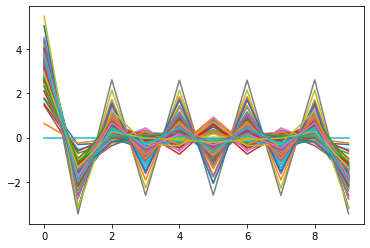

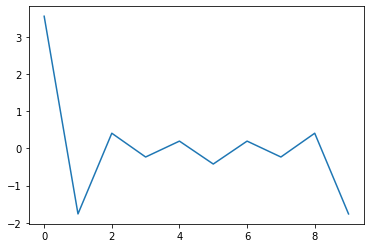

In [0]:
plt.plot(corzl.T);
plt.show()
plt.plot(np.mean(corzl[-5:],axis=0));

ploting the measured sz correlation and the exact sz correlation at a same plot

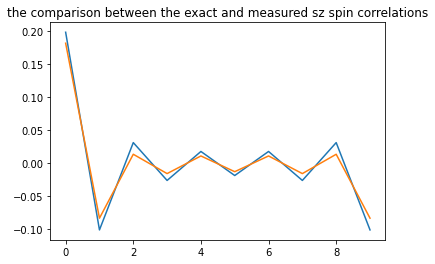

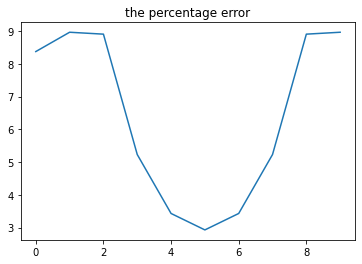

In [0]:
exact_sz = [ 0.198352627762779,	-0.101247175598184,	0.0310913997991300,	
            -0.0262621905610368,	0.0176536688040350,	-0.0188078216029583,
            0.0176536688040350,	-0.0262621905610368,	0.0310913997991300,
            -0.101247175598184]
plt.plot(exact_sz)
plt.title("the comparison between the exact and measured sz spin correlations")
plt.plot(sz_avg)
plt.show()
plt.title("the percentage error")
plt.plot(np.abs(sz_avg-exact_sz)/np.max([sz_avg,exact_sz])*100)

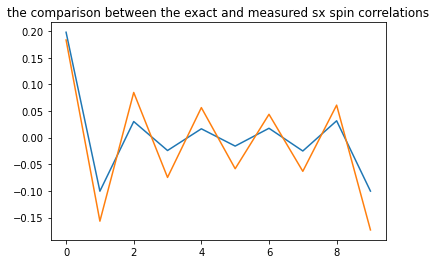

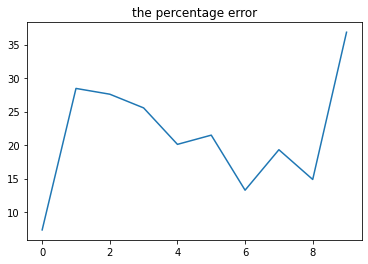

In [0]:
exact_sx = [ 0.197791072995935,	-0.100565496084799,	0.0301953370586673,
            -0.0242137014057402,	0.0165472164073945,	-0.0159009022965765,
            0.0175417593634115,	-0.0251202647537623,	0.0315757935204978,
            -0.100409717252141]
plt.plot(exact_sx)
plt.title("the comparison between the exact and measured sx spin correlations")
plt.plot(sx_avg)
plt.show()
plt.title("the percentage error")
plt.plot(np.abs(sx_avg-exact_sx)/np.max([sx_avg,exact_sx])*100)

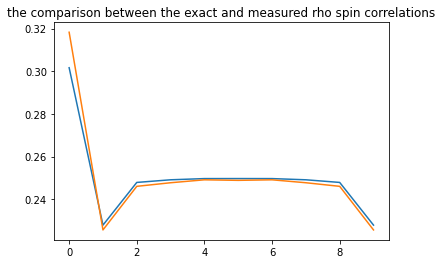

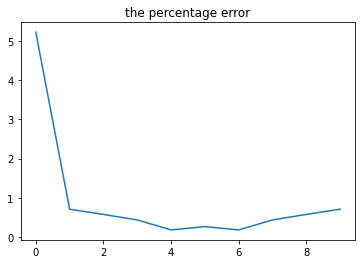

In [0]:
exact_rho = [0.301647372237224,	0.227945771424088,	0.247931414206887,
             0.249166807644633,	0.249726612769297,	0.249742310054161,
             0.249726612769297,	0.249166807644633,	0.247931414206887,
             0.227945771424088]
plt.plot(exact_rho)
plt.title("the comparison between the exact and measured rho spin correlations")
plt.plot(rho_avg)
plt.show()
plt.title("the percentage error")
plt.plot(np.abs(rho_avg-exact_rho)/np.max([rho_avg,exact_rho])*100)

In [0]:
np.abs(rho_avg-exact_rho)/np.max([rho_avg,exact_rho])*100

array([4.32207638, 2.29928855, 0.12118578, 0.00570079, 0.00469703,
       0.00629025, 0.00469703, 0.00570079, 0.12118578, 2.29928855])

In [0]:
El/nms,np.abs(sz_avg-exact_sz)/np.max([sz_avg,exact_sz])*100


(-0.6872951674448627,
 array([6.16747542, 5.18023685, 3.01534323, 1.44037453, 1.67601901,
        1.27604653, 1.67601901, 1.44037453, 3.01534323, 5.18023685]))

calculating the mean energy of the model

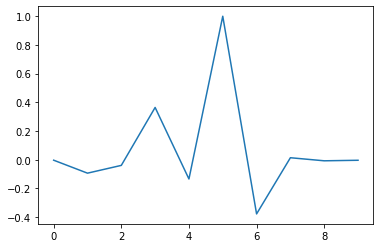

In [0]:
kinetic_energy, interaction_energy, density = -0.9724, 0.4132, 1.0000 
normalized_onsite_correlation, energy = 0.4132, -0.5593 
statistical_error_bar, average_sign = 0.6915, 1.0000

In [0]:
El = []
# for i in range(mrk):
E = measure.energy_avg(n_up_dn_mrk, k, GF_up_mrk + GF_dn_mrk, hubbard.Ns)
    # print("energy",E)
    # El.append(E)
print("mean energy",np.sum(E)/mrk)

avg [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (10, 10) (10, 10)
mean energy 0.0


In [0]:
dqmcreal = []
kk = 0


# ymax  = 1
# trainmean = 0
# testmean =  0
sign =1
for d,e in zip(x_test[:20],y_test[:20]*ymax+(testmean)):
    # print(kk)
    # kk+=1
    # d = np.reshape(d[:,:,0],(1,400))
    # d = np.reshape(d,(10,40))
    # d = d.T
    # print(d.shape)
    hr,_,sd,sign = H(d,expmk,expmkkr,expmkr,p_vec,sign)
    md = model.predict([np.reshape(d,(1,40,10,1))])*ymax+trainmean
    print(e,hr,md)
    dqmcreal.append(hr-e)

In [0]:
a = [2,3,1,4,5,1]
b = [1,1,5,1,1,1]

S= np.maximum(a,b) == b

In [0]:
for i in range(len(S)):
    print(int(S[i]))
    if S[i]==True:
        print("s")
        S[i] = 2

In [0]:
S

In [0]:
np.random.random(10)

In [0]:
np.shape(x_test)

In [0]:
model.predict(x_test)

array([[-146.26144],
       [-180.62962],
       [-172.71233],
       [-183.16547],
       ...,
       [-166.94547],
       [-158.62936],
       [-166.48332],
       [-154.68614]], dtype=float32)

In [0]:
tf.keras.backend.set_learning_phase(0)


In [0]:
model(x_test)

NameError: ignored

Text(0.5, 1.0, 'cost function')

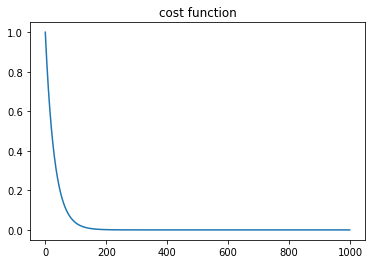

In [0]:
x = [i for i in range(1000)]
y = [np.exp(-x[i]/30) for i in range(1000)]
plt.plot(y)
plt.title("cost function")

In [0]:
# for i in range(200):
#     plt.imshow(model.layers[1].weights[0][:][:][0][i])
len(model.layers)
plt.style.use('default')


NameError: ignored

IndexError: ignored

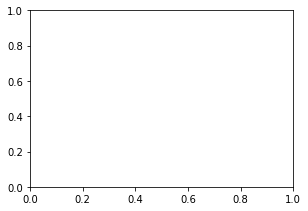

In [0]:
import matplotlib.pyplot as plt

# plt.imshow(np.array(model.get_weights()[0])[:,:,0,1])
plt.figure(figsize=(50, 50))
for i in range(1,20):
    plt.subplot(13,9,i)
    plt.imshow(np.array(model.get_weights()[2])[:,:,0,i],)
    # print(np.sum(np.array(model.get_weights()[2])[:,:,i,0]))
plt.show()
plt.figure(figsize=(50, 50))
for i in range(1,20):
    plt.subplot(13,9,i)
    plt.imshow(np.array(model.get_weights()[2])[:,:,0,i],)
    # print(np.sum(np.array(model.get_weights()[2])[:,:,i,0]))
plt.show()

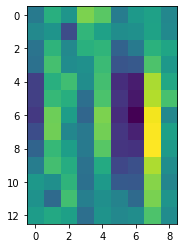

In [0]:
for i in range(12):
    print(np.array(model.get_weights()[i]).shape)

IndexError: ignored

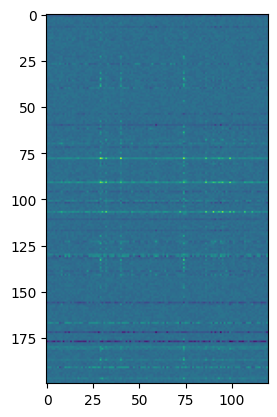

In [0]:
plt.imshow(model.get_weights()[6])

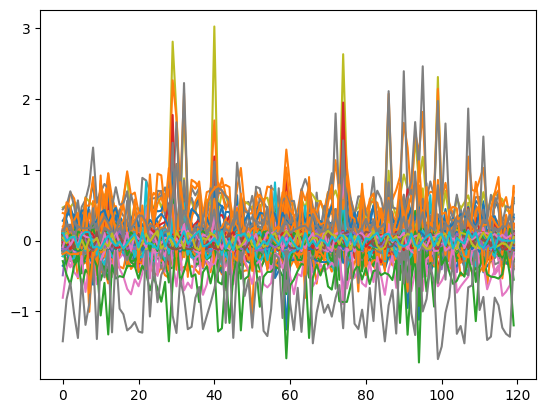

In [0]:
for i in range(200):
    plt.plot(model.get_weights()[6][i,:])

In [0]:
S = np.array([np.reshape(hubbard.interaction(),(40,10,1)) for i in range(1000)])

In [0]:
def predict1(S):
    for i in range(1000):
        model(S)
def predict2(S):
    for i in range(1000):
        model.predict(S)
def predict3(S):
    for i in range(1000):
        model.predict_on_batch(S)

In [59]:
%prun predict2(S)
# predict2(S)

In [30]:
predict1(S)

<tf.Tensor: shape=(1000, 1), dtype=float32, numpy=
array([[-118.49696 ],
       [-109.686104],
       [-120.17399 ],
       [-117.4448  ],
       ...,
       [-114.96363 ],
       [-117.29054 ],
       [-113.92278 ],
       [-118.998184]], dtype=float32)>

In [60]:
5.57/54.205

0.10275804815053963

In [61]:
54.205/11.227

4.82809299011312